Problem 4

Bayes' rule with Bernoulli mixtures

In [48]:
import numpy as np
import scipy
%matplotlib inline

import matplotlib.pyplot as plt

data=np.float64(np.load('MNIST_data.npy'))
label=np.float32(np.load('MNIST_labels.npy'))
data = data/255

In [49]:
#binarize the data
data = [[1 if data[i,j]>0.5 else 0 for j in range(784)] for i in range(70000)]

In [50]:
data = np.array(data)

In [51]:
#First I need to separate data
p=np.random.permutation(len(data))
data = data[p]
label = label[p]
d_train = data[0:42000]
d_develop = data[42000:42000+14000]
d_test = data[42000+14000:42000+14000+14000]

l_train = label[0:42000]
l_develop = label[42000:42000+14000]
l_test = label[42000+14000:42000+14000+14000]

In [52]:
def bernoulliEm(X,M):
    N,d=X.shape
    
    w=np.random.rand(N,M)
    w=w/np.sum(w,axis=1,keepdims=True)
    
    L=0
    i=0
    numIter = 20
    done=False
    while (i<numIter and not done):
        
        # Log p 
        
        pi=(np.sum(w,axis=0)+1)
        pi=pi/(M+N) # 1 x m
        pi=np.reshape(pi,(-1,1))
        p=np.matmul(w.T,X)+1 # m x d
        p=p/(np.sum(w.T,axis=1).reshape(-1,1)+2)
        
        logP=np.log(p)
        log1MinP=np.log(1-p)
        
        
        # Log likelihoods w.r.t to each cluster in one matrix multiplication.
        w=np.matmul(X,(logP-log1MinP).T)+np.sum(log1MinP.T,axis=0).reshape(1,-1)+np.log(pi).reshape(1,-1) # N x m
        # The marginal log likelihood (divided by number of samples to get reasonable numbers)
        Lold=L
        L=np.mean(np.log(np.sum(np.exp(w),axis=1)))
        #print(i,L)
        # Avoid dividing by small numbers:
        maxW=np.max(w,axis=1).reshape(N,1)
        w=np.exp(w-maxW)
        # find responsibilities (E step)
        w = w / np.sum(w, axis=1).reshape(-1, 1)
        # calculate new parameters (M step)
        pi=(np.sum(w,axis=0)+1)
        pi=pi/(M+N) # 1 x m
        pi=np.reshape(pi,(-1,1))
        p=np.matmul(w.T,X)+1 # m x d
        p=p/(np.sum(w.T,axis=1).reshape(-1,1)+2)
        if (i>0 and (L-Lold)/np.abs(Lold) < .0001):
            done=True
        i=i+1
    
    return({'pi':pi, 'p':p})

In [53]:
def plotDigit(p,M):
    #create array of subplots
    fig, axs = plt.subplots(1,M,dpi=50)   
    fig.set_figwidth(10,forward=True)
    fig.set_figheight(10,forward=True)
    
    d=p.shape[1]
    
    #axs=axs.flatten()
    count=0
    for row in p:
        #imshow creates a heatmap
        axs[count].imshow(row.reshape(int(np.sqrt(d)),int(np.sqrt(d))),vmin=0,vmax=1)
        count+=1

In [54]:
d_develop_n = [0] * 10
for i in range(10):
    d_develop_n[i] = d_develop[(l_develop==i).nonzero()[0]]


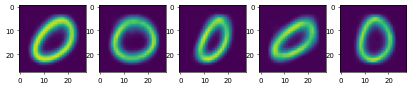

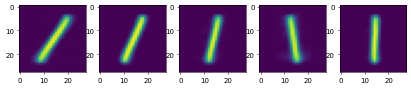

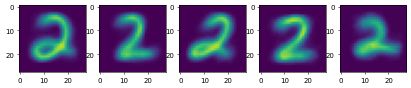

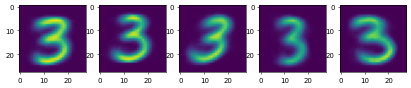

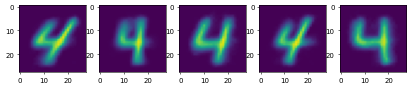

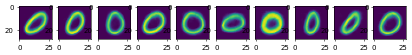

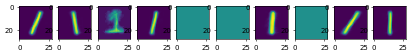

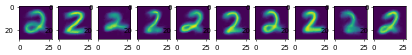

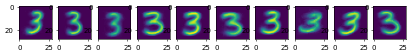

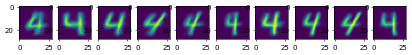

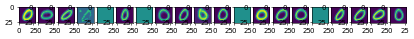

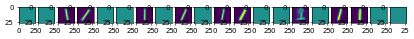

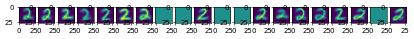

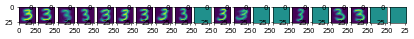

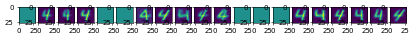

In [55]:
for M in [5, 10,20]:
    # For each digit class, use EM to learn a mixture of M digit models.
    for i in range(5):
        alpha = np.repeat(1.1, M).reshape(1,-1) # Hyper-parameters.
        p=[]
        pi=[]
        X = d_develop_n[i]
        emResult = bernoulliEm(X, M)
        pi+=[emResult['pi']]
        p+=[emResult['p']]
        
        # combine models
        p=np.concatenate(p,axis=0) # c*(m x d)
        pi=np.concatenate(pi,axis=1) # 1 x (m*c)

        # score test data
        logP=np.log(p)
        log1MinP=np.log(1-p)
        
        # Plot digit models.
        plotDigit(p,M)

We can quickly observe that M=5 would be an optimal choice that keeps classification rate while preserving complexity of the model.

In [56]:
d_td = np.array([*d_train, *d_develop])
l_td = np.array([*l_train, *l_develop])
d_td_n = [0] * 10
for i in range(10):
    d_td_n[i] = d_td[(l_td==i).nonzero()[0]]

In [57]:
td_em = [0] * 10
for i in range(10):
    td_em[i] = bernoulliEm(d_td_n[i], 5)

In [59]:
l_emtest = [0] * len(d_test)
for k in range(len(d_test)):
    ppi = [0] * 5
    bayes_p = [0] * 10
    for j in range(10):
        for i in range(5):
            ppi[i] = np.prod(td_em[j].get('p')[i][d_test[k].nonzero()[0]])
        bayes_p[j] = np.dot(ppi, td_em[j].get('pi'))
    l_emtest[k] = np.argmax(bayes_p)

In [60]:
#This is the classification rate for Bayes' rule with Bernoulli mixtures
sum(l_emtest == l_test)/len(l_emtest)

0.786

Logistic regression

In [452]:
#let us get the raw data
data=np.float64(np.load('MNIST_data.npy'))
label=np.float32(np.load('MNIST_labels.npy'))
data = data/255

In [453]:
p=np.random.permutation(len(data))
data = data[p]
label = label[p]
d_train = data[0:42000]
d_develop = data[42000:42000+14000]
d_test = data[42000+14000:42000+14000+14000]

l_train = label[0:42000]
l_develop = label[42000:42000+14000]
l_test = label[42000+14000:42000+14000+14000]

In [63]:
from sklearn.linear_model import LogisticRegression
for i in [1e-2, 1e-1, 1, 10, 100, 1000, 10000]:
    lg = LogisticRegression(fit_intercept = True, C=i, penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs')
    lg.fit(d_train, l_train)
    print('classification rate for C value ' + str(i) + ' is ' + str(np.sum(lg.predict(d_develop) == l_develop)/len(l_develop)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.01 is 0.9091428571428571


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.1 is 0.9175


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1 is 0.9156428571428571


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 10 is 0.9153571428571429


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 100 is 0.915


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1000 is 0.9151428571428571
classification rate for C value 10000 is 0.9161428571428571


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


When C=0.1, this solver gives the maximum classification rate for the development set (it reached the maximum number of iterations - if one has the faster ram, we can change the maximum number of iterations to get a better rate). Let us retrain with development set and training set combined and calculate the error rate on test data.

In [64]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(fit_intercept = True, C=0.1, penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs')
lg.fit([*d_train, *d_develop], [*l_train, *l_develop])
print('classification rate is ' + str(np.sum(lg.predict(d_test) == l_test)/len(l_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate is 0.92


PCA Projections

In [139]:
def PCA(X):

    xxp=X

    mxxp=np.mean(xxp,axis=0)
    txxp=xxp-mxxp
    n=X.shape[0]
    S=np.matmul(np.transpose(txxp),txxp)/n

    e,v = scipy.linalg.eigh(S)

    #print('eigenvalues',e)

    return e,v, mxxp

def PCA_transform(X,d,v,means):
    
    V=v[:,-d:]
    P=np.dot(X-means,V)
    REC = np.dot(P,V.transpose())+means
    return P, REC

In [140]:
data_p = [0] * 5
k = [10, 50, 100, 300, 500]
d_train_pca = [0] * 5
d_develop_pca = [0] * 5
d_test_pca = [0] * 5
l_train_pca = [0] * 5
for i in range(5):
    e, v, means = PCA(data)
    P, data_p[i] = PCA_transform(data, k[i], v, means)
    d_train_pca[i] = data_p[i][0:42000]
    d_develop_pca[i] = data_p[i][42000:42000+14000]
    d_test_pca[i] = data_p[i][42000+14000:42000+14000+14000]

In [144]:
from sklearn.linear_model import LogisticRegression
for i in [0.01, 1, 100]:
    for j in range(5):
        lg = LogisticRegression(fit_intercept = True, C=i, penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs')
        lg.fit(d_train_pca[j], l_train)
        print('classification rate for C value ' + str(i) + ' and ' + str(k[j]) + ' principal components is ' + str(np.sum(lg.predict(d_develop_pca[j]) == l_develop)/len(l_develop)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.01 and 10 principal components is 0.7850714285714285


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.01 and 50 principal components is 0.8927857142857143


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.01 and 100 principal components is 0.9017142857142857


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.01 and 300 principal components is 0.9042857142857142


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 0.01 and 500 principal components is 0.9037857142857143


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1 and 10 principal components is 0.7873571428571429


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1 and 50 principal components is 0.8972142857142857


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1 and 100 principal components is 0.9095714285714286


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1 and 300 principal components is 0.9130714285714285


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 1 and 500 principal components is 0.9134285714285715


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 100 and 10 principal components is 0.7874285714285715


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 100 and 50 principal components is 0.8973571428571429


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 100 and 100 principal components is 0.9095


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification rate for C value 100 and 300 principal components is 0.9127857142857143
classification rate for C value 100 and 500 principal components is 0.9131428571428571


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We have a maximum classification rate when we use C as 1 and 500 principal components. Let us get a classification rate on test data.

In [145]:
np.sum(lg.predict(d_test_pca[3]) == l_test)/len(l_test)

0.9327857142857143

This number is a little less than the classification rate we got from raw data, but there isn't much difference. (0.9327 vs. 0.9347)

Stochastic gradient descent

In [504]:
def min_grad_unreg(theta, x, y):
    a=x*np.exp(np.dot(theta[y], x))
    b=np.sum([np.exp(np.dot(theta[i], x)) for i in range(10)])
    c=-1 * np.array(x) * np.exp(2 * np.dot(theta[y], x))
    return a/b+c/(b*b)

def min_grad(theta, x, y, lam):
    a=x*np.exp(np.dot(theta[y], x))
    b=np.sum([np.exp(np.dot(theta[i], x)) for i in range(10)])
    c=-1 * np.array(x)* np.exp(2 * np.dot(theta[y], x))
    d=[-2*lam*theta[y][i] for i in range(len(theta[y]))]
    return a/b+c/(b*b)+d

In [457]:
def loss(X,Y,theta):
    return -np.log(np.sum([np.exp(np.dot(theta[int(Y[i])], X[i]))/np.sum([np.exp(np.dot(theta[j], X[i])) for j in range(10)]) for i in range(len(X))]))

In [445]:
def shuffle(data, label):
    p=np.random.permutation(len(data))
    data = data[p]
    label = label[p]
    return data, label

In [446]:
#imagine that 
import random
def randomgenerate(leng):
    a = [0] * (leng//100)
    for i in range(leng//100):
        a[i] = random.randrange(100*i, 100*(i+1))
    return a
    

when lambda = 10, 100, unregularized

In [470]:
theta = [[0] * 784] * 10
delta = 0.001

In [ ]:
def find_label(data, theta):
    return np.argmax([np.exp(np.dot(theta[i], data)) for i in range(10)])

In [488]:
a=True
def training_lam(data, label, loss_threshold, lam):
    theta = [[0] * 784] * 10
    a = True
    while (a):
        ori = loss(data, label, theta)
        data, label = shuffle(data, label)
        g = randomgenerate(len(data))
        for i in range(len(g)):
            theta[int(label[g[i]])] = theta[int(label[g[i]])] + delta * min_grad(theta, data[g[i]], int(label[g[i]]), lam)
        if np.abs(loss(data, label, theta)-ori)<loss_threshold:
            a=False
    return theta

In [505]:
theta = training_lam(d_train, l_train, 0.1, 10)
sum([find_label(d_develop[i], theta) for i in range(len(d_develop))]==l_develop)/len(l_develop)


0.2912142857142857

In [506]:
theta = training_lam(d_train, l_train, 0.1, 100)
sum([find_label(d_develop[i], theta) for i in range(len(d_develop))]==l_develop)/len(l_develop)


0.5140714285714286

In [ ]:
a=True
def training_unreg(data, label, loss_threshold):
    theta = [[0] * 784] * 10
    a = True
    while (a):
        ori = loss(data, label, theta)
        data, label = shuffle(data, label)
        g = randomgenerate(len(data))
        for i in range(len(g)):
            theta[int(label[g[i]])] = theta[int(label[g[i]])] + delta * min_grad_unreg(theta, data[g[i]], int(label[g[i]]))
        if np.abs(loss(data, label, theta)-ori)<loss_threshold:
            a=False
    return theta

In [517]:
theta = training_unreg(d_train, l_train, 0.01)
sum([find_label(d_develop[i], theta) for i in range(len(d_develop))]==l_develop)/len(l_develop)

0.09778571428571428

When lambda = 100, we have the best classification rate.
Now retrain with training+development data combined.

In [514]:
training_data = np.array([*d_train, *d_develop])
training_label = np.array([*l_train, *l_develop])

In [515]:
p=np.random.permutation(len(training_data))

In [516]:
theta = training_lam(training_data, training_label, 0.01, 100)
sum([find_label(d_test[i], theta) for i in range(len(d_test))]==l_test)/len(l_test)

0.5164285714285715

This is a classification rate. Stochastic gradient descent method does give me pretty bad error rate but in terms of time, it's faster than logistic regression. 